# FEATURE 선정
# 모델 선정
# TARGET 선정(3개)
# VALIDATION 선정(2개)
# ROLLING 여부

- ACTIVE ETF: UNIVERSE

In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=True, save_file=True)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2020-02-04 15:35:30,200 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:35:30,203 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:35:30,204 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:35:30,215 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:33,838 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:37,663 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:14,490 - EPM - INFO - [STEP 1 - 4] SAVE RETURN DATA INTO CSV FORMAT


In [7]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

# 1. FEATURE

### average return

In [11]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [12]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [13]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [14]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# 2. 성과

# CASE 0. 기존(머신러닝 사용 X)

In [15]:
from EPM import EPM

In [16]:
epm = EPM(strategy_name="EPM", asset_type="EQUITY")
epm.load_index_and_return(from_db=True, save_file=True)
epm.load_strategy_data(table='datastream', origin='EPS')
epm.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
epm.calculate_signal(minobs1=52, longlen=52, longlen2=13, shortlen=2, CS=0.35)
epm.set_portfolio_parameter(cs_strategy_type='notional')
epm.make_portfolio()

2020-02-04 15:36:15,730 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:36:15,730 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:36:15,732 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:36:15,732 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:36:15,733 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:36:15,733 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:36:15,735 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:15,735 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:19,974 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:19,974 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:23,045 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:23,045 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:57,282 - EPM - INFO - [STEP 1 -

In [17]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
epm_comp_df = pd.read_csv('../check/past/epm.csv', header=0, index_col=0, parse_dates=True)
epm_lag_comp_df = pd.read_csv('../check/past/epm_lag.csv', header=0, index_col=0, parse_dates=True)

### 1. PYTHON & R

In [70]:
epm.index

ticker           CAC       AEX       SPX       DAX       HSI      IBEX  \
tdate                                                                    
1993-01-04  0.992572  1.005232  0.999243  1.000105  0.985886  1.006423   
1993-01-05  1.001861  1.014340  0.997175  1.010299  1.010080  1.033881   
1993-01-06  0.998436  1.019308  0.998664  1.005518  1.001144  1.033881   
1993-01-07  0.994699  1.018563  0.987082  0.995960  0.994604  1.032829   
1993-01-08  0.998955  1.008213  0.985943  0.992458  0.998310  1.034978   
...              ...       ...       ...       ...       ...       ...   
2019-11-19  3.421076  5.540146  5.448947  4.747421  6.342105  4.653551   
2019-11-20  3.412668  5.517578  5.432348  4.729821  6.277464  4.642433   
2019-11-21  3.405131  5.477364  5.423611  4.726230  6.192681  4.636166   
2019-11-22  3.412089  5.504112  5.436716  4.727128  6.235307  4.652692   
2019-11-25  3.431222  5.540703  5.473846  4.757658  6.329692  4.688980   

ticker           NKY       TSX        OMX        SG       SMI       MIB  \
tdate                                                                     
1993-01-04  0.999114  1.000657   1.020311  1.002135  1.006885  1.012275   
1993-01-05  0.990578  1.000742   1.047219  1.019707  1.011055  1.016393   
1993-01-06  0.983279  0.999984   1.047219  1.009473  1.010808  1.016393   
1993-01-07  0.983279  0.987718   1.035753  1.004040  0.993534  1.023719   
1993-01-08  0.983279  0.984437   1.032266  0.999264  0.991939  1.027235   
...              ...       ...        ...       ...       ...       ...   
2019-11-19  1.542789  6.056815  16.249037  2.814686  6.996423  3.650149   
2019-11-20  1.530550  6.050271  16.109140  2.807904  7.008591  3.655156   
2019-11-21  1.525257  6.046107  16.053181  2.775127  6.984255  3.644672   
2019-11-22  1.529558  6.030046  16.099813  2.806397  7.013999  3.642325   
2019-11-25  1.542458  6.058004  16.258362  2.788313  7.070781  3.669863   

ticker          AS51      FTSE  
tdate                           
1993-01-04  1.009817  1.006984  
1993-01-05  1.012132  0.998232  
1993-01-06  0.992386  0.995097  
1993-01-07  0.983248  0.991776  
1993-01-08  0.962400  0.987059  
...              ...       ...  
2019-11-19  4.108440  2.537561  
2019-11-20  4.045799  2.519682  
2019-11-21  4.018694  2.509962  
2019-11-22  4.047606  2.541900  
2019-11-25  4.060857  2.566549  

[7009 rows x 14 columns]

In [18]:
tester = Tester(epm)
tester.set_period(start=start_date, end=end_date)
tester.run()

2020-02-04 15:38:07,717 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:07,717 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:07,718 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:38:07,718 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES


EPM
0% [############################# ] 100% | ETA: 00:00:00

2020-02-04 15:38:11,257 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:38:11,257 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


EPM
0% [############################# ] 100% | ETA: 00:00:00

In [19]:
to_plot = (1.+ epm_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [20]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [21]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [22]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [23]:
def train_tree(train_x, train_y1, val_x, val_y1, max_depth=7, fraction=0.8, num_leaves=50, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, random_state=1, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': max_depth,
          'num_leaves': num_leaves,
          "learning_rate": learning_rate,
          "feature_fraction": fraction,
          "subsample": fraction,
          "verbosity": verbose,
          "metric": 'binary_logloss',
          'random_state': random_state
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [24]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692944	valid_1's binary_logloss: 0.693143
[20]	training's binary_logloss: 0.692758	valid_1's binary_logloss: 0.693133
[30]	training's binary_logloss: 0.692565	valid_1's binary_logloss: 0.693142
[40]	training's binary_logloss: 0.692369	valid_1's binary_logloss: 0.693137
[50]	training's binary_logloss: 0.692171	valid_1's binary_logloss: 0.693146
[60]	training's binary_logloss: 0.691972	valid_1's binary_logloss: 0.693162
[70]	training's binary_logloss: 0.691771	valid_1's binary_logloss: 0.693167
[80]	training's binary_logloss: 0.691594	valid_1's binary_logloss: 0.693171
[90]	training's binary_logloss: 0.69141	valid_1's binary_logloss: 0.693182
[100]	training's binary_logloss: 0.691226	valid_1's binary_logloss: 0.693207
[110]	training's binary_logloss: 0.691045	valid_1's binary_logloss: 0.693223
[120]	training's binary_logloss: 0.690854	valid_1's binary_logloss: 0.693252
Early stopping, best ite

In [25]:
%matplotlib inline

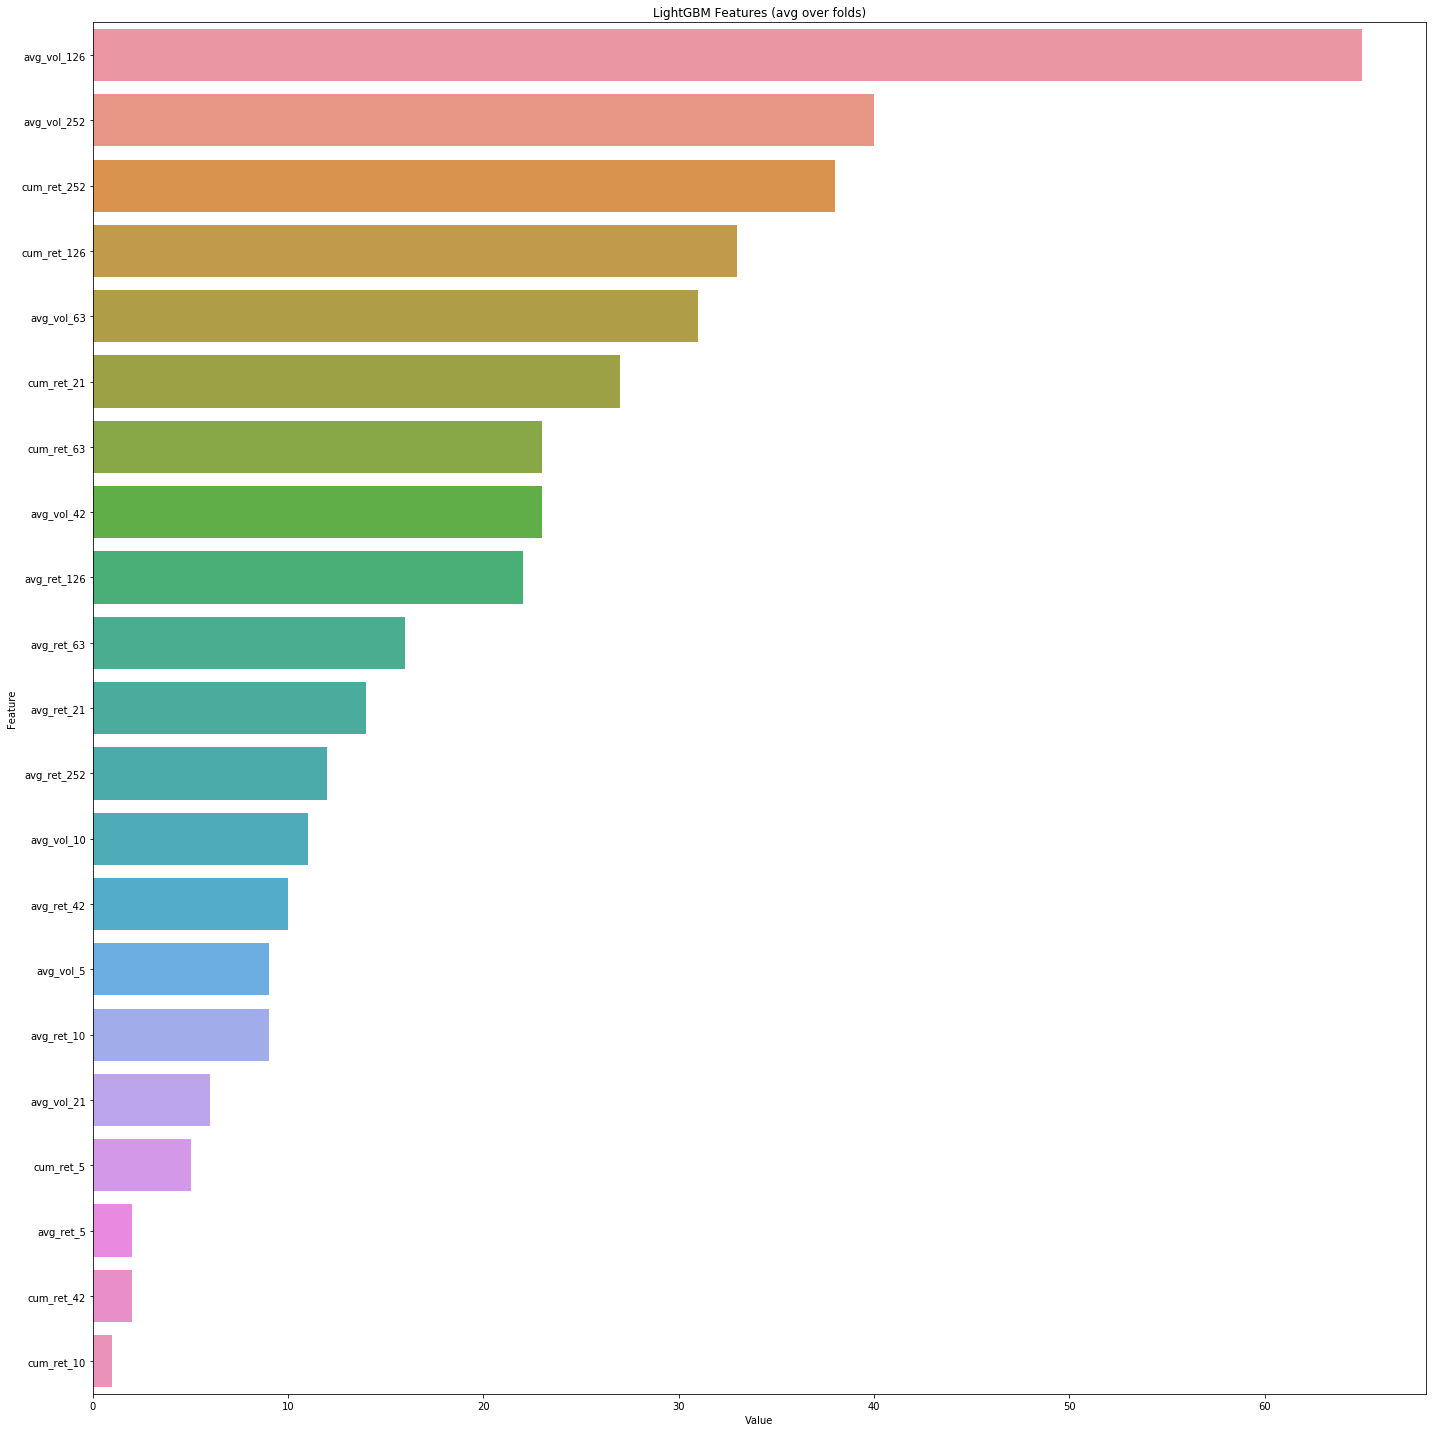

In [26]:
supply_demand_feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), df_train.columns[3:])), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=supply_demand_feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [27]:
test_pred = model.predict(df_test_x.values)

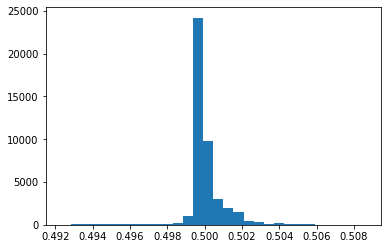

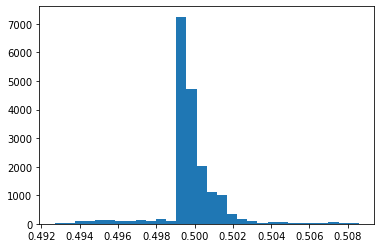

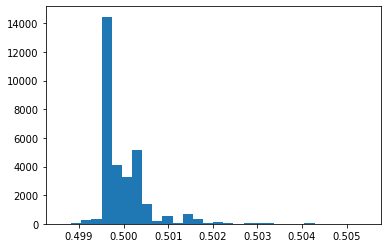

In [28]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [29]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')
df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [30]:
df_index_sub = df_index.loc['1994':]
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [31]:
strategy.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2020-02-04 15:38:16,940 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:38:16,940 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:38:16,941 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:38:16,941 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:38:16,942 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:38:16,942 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:38:16,943 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:38:16,943 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:39:16,165 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2020-02-04 15:39:16,165 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2020-02-04 15:39:16,165 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2020-02-04 15:39:16,165 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2020-02-04 15:39:17,851 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2020-02-04 15:39:17,851 - EPM - 

### TEST

In [32]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run(use_bt=False)

2020-02-04 15:39:24,366 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:39:24,366 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:39:24,367 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:39:24,367 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:39:24,861 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:39:24,861 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [33]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [34]:
to_plot.iplot()

### 기존 전략보다는 좋아보인다.

# CASE 2. 70% 강조

- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [35]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

In [ ]:
df_in

In [36]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 3 * 2
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [37]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [38]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.651523	valid_1's binary_logloss: 0.651738
[20]	training's binary_logloss: 0.651296	valid_1's binary_logloss: 0.651712
[30]	training's binary_logloss: 0.651074	valid_1's binary_logloss: 0.65168
[40]	training's binary_logloss: 0.650876	valid_1's binary_logloss: 0.65166
[50]	training's binary_logloss: 0.650652	valid_1's binary_logloss: 0.651635
[60]	training's binary_logloss: 0.650435	valid_1's binary_logloss: 0.651637
[70]	training's binary_logloss: 0.650217	valid_1's binary_logloss: 0.651633
[80]	training's binary_logloss: 0.650028	valid_1's binary_logloss: 0.651601
[90]	training's binary_logloss: 0.649832	valid_1's binary_logloss: 0.651595
[100]	training's binary_logloss: 0.64964	valid_1's binary_logloss: 0.651618
[110]	training's binary_logloss: 0.649452	valid_1's binary_logloss: 0.651605
[120]	training's binary_logloss: 0.649251	valid_1's binary_logloss: 0.651596
[130]	training's binary_lo

In [39]:
test_pred = model.predict(df_test_x.values)

In [40]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [41]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [42]:
strategy2 = EPM(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=True, save_file=True)
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2020-02-04 15:39:27,317 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:39:27,317 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:39:27,317 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:39:27,320 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:27,320 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:27,320 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:27,321 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:27,321 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:27,321 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:27,325 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:39:27,325 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:39:27,325 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:39:32,867 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:39:32,867 - E

### TEST

In [43]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run(use_bt=False)

2020-02-04 15:41:23,286 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:41:23,286 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:41:23,286 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:41:23,288 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:41:23,288 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:41:23,288 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:41:23,857 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:41:23,857 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:41:23,857 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [44]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [45]:
to_plot.iplot()

In [46]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [47]:
result

EPM                  EPM         0  \
CAGR                                   NaN                  NaN  0.000104   
CAGR_TR                                NaN                  NaN -0.002452   
MDD                                    NaN                  NaN -0.072013   
SHARPE                                 NaN                  NaN  0.015360   
SHARPE_TR                              NaN                  NaN -0.104449   
TURNOVER                               NaN                  NaN  2.358811   
VOL                                    NaN                  NaN  0.001320   
avg_down_month                  -0.0049551          -0.00370966       NaN   
avg_drawdown                    -0.0103609          -0.00413092       NaN   
avg_drawdown_days                   131.75              47.3585       NaN   
avg_up_month                    0.00448277           0.00326722       NaN   
best_day                        0.00796003           0.00620432       NaN   
best_month                         0.02075           0.00891486       NaN   
best_year                        0.0120427              0.03913       NaN   
cagr                           -0.00111907           0.00848198       NaN   
calmar                           -0.021373             0.295018       NaN   
daily_kurt                         2.28373              3.00473       NaN   
daily_mean                     -0.00086247           0.00830958       NaN   
daily_sharpe                     -0.041238             0.472209       NaN   
daily_skew                        0.128536            -0.283862       NaN   
daily_sortino                   -0.0685926             0.751789       NaN   
daily_vol                        0.0209145            0.0175973       NaN   
end                    2018-05-09 00:00:00  2018-05-09 00:00:00       NaN   
five_year                      0.000290164            0.0103547       NaN   
incep                          -0.00111907           0.00848198       NaN   
max_drawdown                    -0.0523588           -0.0287508       NaN   
monthly_kurt                      0.876806             0.314617       NaN   
monthly_mean                   -0.00283401           0.00876205       NaN   
monthly_sharpe                   -0.134227             0.567721       NaN   
monthly_skew                      0.138768            -0.430282       NaN   
monthly_sortino                  -0.222289             0.957123       NaN   
monthly_vol                      0.0211135            0.0154337       NaN   
mtd                             0.00255968           0.00030019       NaN   
one_year                        -0.0241998           0.00977179       NaN   
rf                                       0                    0       NaN   
six_month                      0.000610244          -0.00231112       NaN   
start                  2011-01-02 00:00:00  2011-01-02 00:00:00       NaN   
ten_year                       -0.00111907           0.00848198       NaN   
three_month                     0.00301387           0.00749245       NaN   
three_year                     -0.00992997           0.00802693       NaN   
total_return                   -0.00819418            0.0640327       NaN   
twelve_month_win_perc             0.461538             0.730769       NaN   
win_year_perc                     0.571429             0.714286       NaN   
worst_day                      -0.00529127          -0.00582487       NaN   
worst_month                     -0.0156009           -0.0110926       NaN   
worst_year                      -0.0326952          -0.00333702       NaN   
yearly_kurt                      -0.885548             -0.78545       NaN   
yearly_mean                     -0.0041083             0.010918       NaN   
yearly_sharpe                    -0.228897             0.608498       NaN   
yearly_skew                      -0.898997              1.12487       NaN   
yearly_sortino                   -0.294842              6.84573       NaN   
yearly_vol                       0.

In [48]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

In [49]:
result

CS_python            TS_python     CS_ML  \
CAGR                                   NaN                  NaN  0.000104   
CAGR_TR                                NaN                  NaN -0.002452   
MDD                                    NaN                  NaN -0.072013   
SHARPE                                 NaN                  NaN  0.015360   
SHARPE_TR                              NaN                  NaN -0.104449   
TURNOVER                               NaN                  NaN  2.358811   
VOL                                    NaN                  NaN  0.001320   
avg_down_month                  -0.0049551          -0.00370966       NaN   
avg_drawdown                    -0.0103609          -0.00413092       NaN   
avg_drawdown_days                   131.75              47.3585       NaN   
avg_up_month                    0.00448277           0.00326722       NaN   
best_day                        0.00796003           0.00620432       NaN   
best_month                         0.02075           0.00891486       NaN   
best_year                        0.0120427              0.03913       NaN   
cagr                           -0.00111907           0.00848198       NaN   
calmar                           -0.021373             0.295018       NaN   
daily_kurt                         2.28373              3.00473       NaN   
daily_mean                     -0.00086247           0.00830958       NaN   
daily_sharpe                     -0.041238             0.472209       NaN   
daily_skew                        0.128536            -0.283862       NaN   
daily_sortino                   -0.0685926             0.751789       NaN   
daily_vol                        0.0209145            0.0175973       NaN   
end                    2018-05-09 00:00:00  2018-05-09 00:00:00       NaN   
five_year                      0.000290164            0.0103547       NaN   
incep                          -0.00111907           0.00848198       NaN   
max_drawdown                    -0.0523588           -0.0287508       NaN   
monthly_kurt                      0.876806             0.314617       NaN   
monthly_mean                   -0.00283401           0.00876205       NaN   
monthly_sharpe                   -0.134227             0.567721       NaN   
monthly_skew                      0.138768            -0.430282       NaN   
monthly_sortino                  -0.222289             0.957123       NaN   
monthly_vol                      0.0211135            0.0154337       NaN   
mtd                             0.00255968           0.00030019       NaN   
one_year                        -0.0241998           0.00977179       NaN   
rf                                       0                    0       NaN   
six_month                      0.000610244          -0.00231112       NaN   
start                  2011-01-02 00:00:00  2011-01-02 00:00:00       NaN   
ten_year                       -0.00111907           0.00848198       NaN   
three_month                     0.00301387           0.00749245       NaN   
three_year                     -0.00992997           0.00802693       NaN   
total_return                   -0.00819418            0.0640327       NaN   
twelve_month_win_perc             0.461538             0.730769       NaN   
win_year_perc                     0.571429             0.714286       NaN   
worst_day                      -0.00529127          -0.00582487       NaN   
worst_month                     -0.0156009           -0.0110926       NaN   
worst_year                      -0.0326952          -0.00333702       NaN   
yearly_kurt                      -0.885548             -0.78545       NaN   
yearly_mean                     -0.0041083             0.010918       NaN   
yearly_sharpe                    -0.228897             0.608498       NaN   
yearly_skew                      -0.898997              1.12487       NaN   
yearly_sortino                   -0.294842              6.84573       NaN   
yearly_vol                   

### ML UPPER가 성과가 좋다.

# CASE 3. Case1을 Rolling으로 실행

In [50]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [51]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [52]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [53]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692982	valid_1's binary_logloss: 0.693126
[20]	training's binary_logloss: 0.692808	valid_1's binary_logloss: 0.693137
[30]	training's binary_logloss: 0.692645	valid_1's binary_logloss: 0.693125
[40]	training's binary_logloss: 0.692469	valid_1's binary_logloss: 0.693146
[50]	training's binary_logloss: 0.692301	valid_1's binary_logloss: 0.693171
[60]	training's binary_logloss: 0.692128	valid_1's binary_logloss: 0.693187
[70]	training's binary_logloss: 0.691958	valid_1's binary_logloss: 0.693205
[80]	training's binary_logloss: 0.691785	valid_1's binary_logloss: 0.69324
[90]	training's binary_logloss: 0.691619	valid_1's binary_logloss: 0.693257
[100]	training's binary_logloss: 0.691453	valid_1's binary_logloss: 0.693291
[110]	training's binary_logloss: 0.691294	valid_1's binary_logloss: 0.693329
[120]	training's binary_logloss: 0.691132	valid_1's binary_logloss: 0.69338
[130]	training's binary_l

[210]	training's binary_logloss: 0.690836	valid_1's binary_logloss: 0.692919
[220]	training's binary_logloss: 0.690739	valid_1's binary_logloss: 0.692908
[230]	training's binary_logloss: 0.690633	valid_1's binary_logloss: 0.692898
[240]	training's binary_logloss: 0.69054	valid_1's binary_logloss: 0.692893
[250]	training's binary_logloss: 0.69044	valid_1's binary_logloss: 0.69289
[260]	training's binary_logloss: 0.690332	valid_1's binary_logloss: 0.692878
[270]	training's binary_logloss: 0.690238	valid_1's binary_logloss: 0.69287
[280]	training's binary_logloss: 0.690141	valid_1's binary_logloss: 0.692869
[290]	training's binary_logloss: 0.690034	valid_1's binary_logloss: 0.692855
[300]	training's binary_logloss: 0.689928	valid_1's binary_logloss: 0.692841
[310]	training's binary_logloss: 0.689827	valid_1's binary_logloss: 0.692832
[320]	training's binary_logloss: 0.689728	valid_1's binary_logloss: 0.69282
[330]	training's binary_logloss: 0.689627	valid_1's binary_logloss: 0.692811
[340

[1290]	training's binary_logloss: 0.681257	valid_1's binary_logloss: 0.692272
[1300]	training's binary_logloss: 0.68117	valid_1's binary_logloss: 0.692267
[1310]	training's binary_logloss: 0.681092	valid_1's binary_logloss: 0.692268
[1320]	training's binary_logloss: 0.681004	valid_1's binary_logloss: 0.692263
[1330]	training's binary_logloss: 0.680923	valid_1's binary_logloss: 0.692261
[1340]	training's binary_logloss: 0.680833	valid_1's binary_logloss: 0.692263
[1350]	training's binary_logloss: 0.680748	valid_1's binary_logloss: 0.692263
[1360]	training's binary_logloss: 0.680679	valid_1's binary_logloss: 0.69226
[1370]	training's binary_logloss: 0.680605	valid_1's binary_logloss: 0.692257
[1380]	training's binary_logloss: 0.680522	valid_1's binary_logloss: 0.692252
[1390]	training's binary_logloss: 0.680437	valid_1's binary_logloss: 0.692254
[1400]	training's binary_logloss: 0.680353	valid_1's binary_logloss: 0.692254
[1410]	training's binary_logloss: 0.680275	valid_1's binary_loglos

[390]	training's binary_logloss: 0.688834	valid_1's binary_logloss: 0.693062
[400]	training's binary_logloss: 0.688738	valid_1's binary_logloss: 0.693064
[410]	training's binary_logloss: 0.688647	valid_1's binary_logloss: 0.693055
[420]	training's binary_logloss: 0.688554	valid_1's binary_logloss: 0.693056
[430]	training's binary_logloss: 0.688455	valid_1's binary_logloss: 0.693066
[440]	training's binary_logloss: 0.688364	valid_1's binary_logloss: 0.693061
[450]	training's binary_logloss: 0.688268	valid_1's binary_logloss: 0.69306
[460]	training's binary_logloss: 0.68817	valid_1's binary_logloss: 0.693055
[470]	training's binary_logloss: 0.688072	valid_1's binary_logloss: 0.693053
[480]	training's binary_logloss: 0.687985	valid_1's binary_logloss: 0.693049
[490]	training's binary_logloss: 0.687896	valid_1's binary_logloss: 0.693043
[500]	training's binary_logloss: 0.687808	valid_1's binary_logloss: 0.693044
[510]	training's binary_logloss: 0.687721	valid_1's binary_logloss: 0.693054
[

[870]	training's binary_logloss: 0.685335	valid_1's binary_logloss: 0.692677
[880]	training's binary_logloss: 0.685262	valid_1's binary_logloss: 0.692667
[890]	training's binary_logloss: 0.685192	valid_1's binary_logloss: 0.692671
[900]	training's binary_logloss: 0.685121	valid_1's binary_logloss: 0.692669
[910]	training's binary_logloss: 0.685055	valid_1's binary_logloss: 0.692661
[920]	training's binary_logloss: 0.684983	valid_1's binary_logloss: 0.69265
[930]	training's binary_logloss: 0.684919	valid_1's binary_logloss: 0.69264
[940]	training's binary_logloss: 0.684855	valid_1's binary_logloss: 0.692634
[950]	training's binary_logloss: 0.684795	valid_1's binary_logloss: 0.692633
[960]	training's binary_logloss: 0.684729	valid_1's binary_logloss: 0.692622
[970]	training's binary_logloss: 0.684659	valid_1's binary_logloss: 0.692601
[980]	training's binary_logloss: 0.684588	valid_1's binary_logloss: 0.692585
[990]	training's binary_logloss: 0.684516	valid_1's binary_logloss: 0.692573
[

[1930]	training's binary_logloss: 0.678322	valid_1's binary_logloss: 0.691774
[1940]	training's binary_logloss: 0.678254	valid_1's binary_logloss: 0.691771
[1950]	training's binary_logloss: 0.678188	valid_1's binary_logloss: 0.691758
[1960]	training's binary_logloss: 0.678119	valid_1's binary_logloss: 0.691753
[1970]	training's binary_logloss: 0.678056	valid_1's binary_logloss: 0.691738
[1980]	training's binary_logloss: 0.677994	valid_1's binary_logloss: 0.691733
[1990]	training's binary_logloss: 0.677935	valid_1's binary_logloss: 0.691729
[2000]	training's binary_logloss: 0.677875	valid_1's binary_logloss: 0.69172
[2010]	training's binary_logloss: 0.677821	valid_1's binary_logloss: 0.69172
[2020]	training's binary_logloss: 0.677761	valid_1's binary_logloss: 0.69171
[2030]	training's binary_logloss: 0.677706	valid_1's binary_logloss: 0.691709
[2040]	training's binary_logloss: 0.677651	valid_1's binary_logloss: 0.691701
[2050]	training's binary_logloss: 0.677591	valid_1's binary_logloss

[620]	training's binary_logloss: 0.687433	valid_1's binary_logloss: 0.691988
[630]	training's binary_logloss: 0.687359	valid_1's binary_logloss: 0.691982
[640]	training's binary_logloss: 0.687289	valid_1's binary_logloss: 0.691975
[650]	training's binary_logloss: 0.687209	valid_1's binary_logloss: 0.691967
[660]	training's binary_logloss: 0.687131	valid_1's binary_logloss: 0.691969
[670]	training's binary_logloss: 0.687058	valid_1's binary_logloss: 0.691963
[680]	training's binary_logloss: 0.686978	valid_1's binary_logloss: 0.691965
[690]	training's binary_logloss: 0.686905	valid_1's binary_logloss: 0.691966
[700]	training's binary_logloss: 0.686836	valid_1's binary_logloss: 0.691971
[710]	training's binary_logloss: 0.686766	valid_1's binary_logloss: 0.691972
[720]	training's binary_logloss: 0.6867	valid_1's binary_logloss: 0.691967
[730]	training's binary_logloss: 0.686628	valid_1's binary_logloss: 0.691973
[740]	training's binary_logloss: 0.686561	valid_1's binary_logloss: 0.691979
[

[950]	training's binary_logloss: 0.685391	valid_1's binary_logloss: 0.692151
[960]	training's binary_logloss: 0.685332	valid_1's binary_logloss: 0.692152
[970]	training's binary_logloss: 0.685263	valid_1's binary_logloss: 0.692147
[980]	training's binary_logloss: 0.685197	valid_1's binary_logloss: 0.692136
[990]	training's binary_logloss: 0.685126	valid_1's binary_logloss: 0.692141
[1000]	training's binary_logloss: 0.685067	valid_1's binary_logloss: 0.692136
[1010]	training's binary_logloss: 0.685004	valid_1's binary_logloss: 0.69213
[1020]	training's binary_logloss: 0.68494	valid_1's binary_logloss: 0.692122
[1030]	training's binary_logloss: 0.684878	valid_1's binary_logloss: 0.69212
[1040]	training's binary_logloss: 0.684812	valid_1's binary_logloss: 0.692128
[1050]	training's binary_logloss: 0.684751	valid_1's binary_logloss: 0.692137
[1060]	training's binary_logloss: 0.684695	valid_1's binary_logloss: 0.692141
[1070]	training's binary_logloss: 0.684635	valid_1's binary_logloss: 0.6

In [54]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([1.2000e+01, 2.2000e+01, 3.4000e+01, 3.5000e+01, 7.0000e+00,
        5.0000e+00, 1.0000e+00, 4.9000e+01, 2.0300e+02, 8.2800e+02,
        3.0600e+03, 1.0850e+04, 1.2339e+04, 2.1320e+03, 6.0900e+02,
        3.4900e+02, 2.7300e+02, 1.0400e+02, 5.0000e+01, 4.7000e+01,
        4.9000e+01, 3.9000e+01, 2.0000e+01, 2.7000e+01, 2.1000e+01,
        3.5000e+01, 5.9000e+01, 2.1000e+01, 6.0000e+00, 4.0000e+00]),
 array([0.38330778, 0.39296267, 0.40261757, 0.41227247, 0.42192736,
        0.43158226, 0.44123716, 0.45089206, 0.46054695, 0.47020185,
        0.47985675, 0.48951164, 0.49916654, 0.50882144, 0.51847633,
        0.52813123, 0.53778613, 0.54744103, 0.55709592, 0.56675082,
        0.57640572, 0.58606061, 0.59571551, 0.60537041, 0.6150253 ,
        0.6246802 , 0.6343351 , 0.64399   , 0.65364489, 0.66329979,
        0.67295469]),
 <a list of 30 Patch objects>)

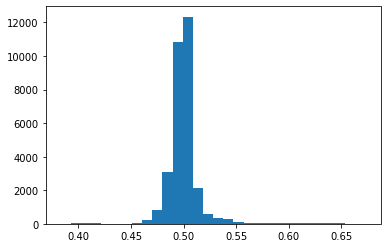

In [55]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [56]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [57]:
strategy3 = EPM(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=True, save_file=True)

2020-02-04 15:41:45,532 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:41:45,532 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:41:45,532 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:41:45,532 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:41:45,534 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:41:45,534 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:41:45,534 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:41:45,534 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:41:45,535 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:41:45,535 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:41:45,535 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:41:45,535 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:41:45,537 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:41:45,537 - EPM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-

In [58]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy2.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2020-02-04 15:42:35,646 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:42:35,646 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:42:35,646 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:42:35,646 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:42:35,647 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:42:35,647 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:42:35,647 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:42:35,647 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:42:35,649 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:42:35,649 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:42:35,649 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:42:35,649 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:42:35,651 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:42:35,651 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:42:35,651 - EPM - INFO -

In [59]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

2020-02-04 15:43:29,483 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:43:29,483 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:43:29,483 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:43:29,483 - EPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:43:29,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:43:29,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:43:29,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2020-02-04 15:43:29,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES


EPM
0% [############################# ] 100% | ETA: 00:00:00

2020-02-04 15:43:32,110 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:43:32,110 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:43:32,110 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2020-02-04 15:43:32,110 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


EPM
0% [############################# ] 100% | ETA: 00:00:00

In [60]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [61]:
to_plot.iplot()

In [62]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [63]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [64]:
result

CS_python            TS_python     CS_ML  \
CAGR                                   NaN                  NaN  0.000104   
CAGR_TR                                NaN                  NaN -0.002452   
MDD                                    NaN                  NaN -0.072013   
SHARPE                                 NaN                  NaN  0.015360   
SHARPE_TR                              NaN                  NaN -0.104449   
TURNOVER                               NaN                  NaN  2.358811   
VOL                                    NaN                  NaN  0.001320   
avg_down_month                  -0.0049551          -0.00370966       NaN   
avg_drawdown                    -0.0103609          -0.00413092       NaN   
avg_drawdown_days                   131.75              47.3585       NaN   
avg_up_month                    0.00448277           0.00326722       NaN   
best_day                        0.00796003           0.00620432       NaN   
best_month                         0.02075           0.00891486       NaN   
best_year                        0.0120427              0.03913       NaN   
cagr                           -0.00111907           0.00848198       NaN   
calmar                           -0.021373             0.295018       NaN   
daily_kurt                         2.28373              3.00473       NaN   
daily_mean                     -0.00086247           0.00830958       NaN   
daily_sharpe                     -0.041238             0.472209       NaN   
daily_skew                        0.128536            -0.283862       NaN   
daily_sortino                   -0.0685926             0.751789       NaN   
daily_vol                        0.0209145            0.0175973       NaN   
end                    2018-05-09 00:00:00  2018-05-09 00:00:00       NaN   
five_year                      0.000290164            0.0103547       NaN   
incep                          -0.00111907           0.00848198       NaN   
max_drawdown                    -0.0523588           -0.0287508       NaN   
monthly_kurt                      0.876806             0.314617       NaN   
monthly_mean                   -0.00283401           0.00876205       NaN   
monthly_sharpe                   -0.134227             0.567721       NaN   
monthly_skew                      0.138768            -0.430282       NaN   
monthly_sortino                  -0.222289             0.957123       NaN   
monthly_vol                      0.0211135            0.0154337       NaN   
mtd                             0.00255968           0.00030019       NaN   
one_year                        -0.0241998           0.00977179       NaN   
rf                                       0                    0       NaN   
six_month                      0.000610244          -0.00231112       NaN   
start                  2011-01-02 00:00:00  2011-01-02 00:00:00       NaN   
ten_year                       -0.00111907           0.00848198       NaN   
three_month                     0.00301387           0.00749245       NaN   
three_year                     -0.00992997           0.00802693       NaN   
total_return                   -0.00819418            0.0640327       NaN   
twelve_month_win_perc             0.461538             0.730769       NaN   
win_year_perc                     0.571429             0.714286       NaN   
worst_day                      -0.00529127          -0.00582487       NaN   
worst_month                     -0.0156009           -0.0110926       NaN   
worst_year                      -0.0326952          -0.00333702       NaN   
yearly_kurt                      -0.885548             -0.78545       NaN   
yearly_mean                     -0.0041083             0.010918       NaN   
yearly_sharpe                    -0.228897             0.608498       NaN   
yearly_skew                      -0.898997              1.12487       NaN   
yearly_sortino                   -0.294842              6.84573       NaN   
yearly_vol                   

# CASE 4. CASE 2를 ROLLING으로 실행

In [65]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [66]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.651554	valid_1's binary_logloss: 0.651746
[20]	training's binary_logloss: 0.651337	valid_1's binary_logloss: 0.651762
[30]	training's binary_logloss: 0.651132	valid_1's binary_logloss: 0.651719
[40]	training's binary_logloss: 0.650906	valid_1's binary_logloss: 0.651705
[50]	training's binary_logloss: 0.650707	valid_1's binary_logloss: 0.651711
[60]	training's binary_logloss: 0.650507	valid_1's binary_logloss: 0.651718
[70]	training's binary_logloss: 0.650312	valid_1's binary_logloss: 0.65172
[80]	training's binary_logloss: 0.650121	valid_1's binary_logloss: 0.651753
[90]	training's binary_logloss: 0.649919	valid_1's binary_logloss: 0.651757
[100]	training's binary_logloss: 0.649721	valid_1's binary_logloss: 0.651753
[110]	training's binary_logloss: 0.649546	valid_1's binary_logloss: 0.651745
[120]	training's binary_logloss: 0.649363	valid_1's binary_logloss: 0.651762
[130]	training's binary_

[480]	training's binary_logloss: 0.64581	valid_1's binary_logloss: 0.651199
[490]	training's binary_logloss: 0.645698	valid_1's binary_logloss: 0.651193
[500]	training's binary_logloss: 0.645588	valid_1's binary_logloss: 0.651187
[510]	training's binary_logloss: 0.645488	valid_1's binary_logloss: 0.65118
[520]	training's binary_logloss: 0.645373	valid_1's binary_logloss: 0.651179
[530]	training's binary_logloss: 0.645266	valid_1's binary_logloss: 0.65118
[540]	training's binary_logloss: 0.645157	valid_1's binary_logloss: 0.651173
[550]	training's binary_logloss: 0.645052	valid_1's binary_logloss: 0.651173
[560]	training's binary_logloss: 0.644949	valid_1's binary_logloss: 0.651168
[570]	training's binary_logloss: 0.644842	valid_1's binary_logloss: 0.651164
[580]	training's binary_logloss: 0.644745	valid_1's binary_logloss: 0.65116
[590]	training's binary_logloss: 0.644646	valid_1's binary_logloss: 0.651154
[600]	training's binary_logloss: 0.644542	valid_1's binary_logloss: 0.651151
[61

[1630]	training's binary_logloss: 0.636004	valid_1's binary_logloss: 0.650477
[1640]	training's binary_logloss: 0.63592	valid_1's binary_logloss: 0.650472
[1650]	training's binary_logloss: 0.635836	valid_1's binary_logloss: 0.650463
[1660]	training's binary_logloss: 0.635767	valid_1's binary_logloss: 0.650464
[1670]	training's binary_logloss: 0.635695	valid_1's binary_logloss: 0.650464
[1680]	training's binary_logloss: 0.63563	valid_1's binary_logloss: 0.650461
[1690]	training's binary_logloss: 0.635554	valid_1's binary_logloss: 0.650452
[1700]	training's binary_logloss: 0.635484	valid_1's binary_logloss: 0.650453
[1710]	training's binary_logloss: 0.635412	valid_1's binary_logloss: 0.650453
[1720]	training's binary_logloss: 0.635335	valid_1's binary_logloss: 0.650453
[1730]	training's binary_logloss: 0.635266	valid_1's binary_logloss: 0.650445
[1740]	training's binary_logloss: 0.635186	valid_1's binary_logloss: 0.650442
[1750]	training's binary_logloss: 0.635115	valid_1's binary_loglos

[620]	training's binary_logloss: 0.645129	valid_1's binary_logloss: 0.650466
[630]	training's binary_logloss: 0.645034	valid_1's binary_logloss: 0.65045
[640]	training's binary_logloss: 0.644947	valid_1's binary_logloss: 0.650434
[650]	training's binary_logloss: 0.644851	valid_1's binary_logloss: 0.650419
[660]	training's binary_logloss: 0.644762	valid_1's binary_logloss: 0.650403
[670]	training's binary_logloss: 0.644674	valid_1's binary_logloss: 0.650384
[680]	training's binary_logloss: 0.644585	valid_1's binary_logloss: 0.650358
[690]	training's binary_logloss: 0.644494	valid_1's binary_logloss: 0.650339
[700]	training's binary_logloss: 0.644405	valid_1's binary_logloss: 0.650327
[710]	training's binary_logloss: 0.64432	valid_1's binary_logloss: 0.650308
[720]	training's binary_logloss: 0.644233	valid_1's binary_logloss: 0.650291
[730]	training's binary_logloss: 0.644146	valid_1's binary_logloss: 0.65028
[740]	training's binary_logloss: 0.644065	valid_1's binary_logloss: 0.650261
[7

[1760]	training's binary_logloss: 0.636371	valid_1's binary_logloss: 0.649108
[1770]	training's binary_logloss: 0.6363	valid_1's binary_logloss: 0.649097
[1780]	training's binary_logloss: 0.636227	valid_1's binary_logloss: 0.649092
[1790]	training's binary_logloss: 0.636161	valid_1's binary_logloss: 0.649088
[1800]	training's binary_logloss: 0.63609	valid_1's binary_logloss: 0.649084
[1810]	training's binary_logloss: 0.636015	valid_1's binary_logloss: 0.649082
[1820]	training's binary_logloss: 0.635947	valid_1's binary_logloss: 0.649075
[1830]	training's binary_logloss: 0.635876	valid_1's binary_logloss: 0.649072
[1840]	training's binary_logloss: 0.635801	valid_1's binary_logloss: 0.649076
[1850]	training's binary_logloss: 0.635736	valid_1's binary_logloss: 0.649078
[1860]	training's binary_logloss: 0.635666	valid_1's binary_logloss: 0.649078
[1870]	training's binary_logloss: 0.635593	valid_1's binary_logloss: 0.649064
[1880]	training's binary_logloss: 0.635521	valid_1's binary_logloss

[2870]	training's binary_logloss: 0.628578	valid_1's binary_logloss: 0.648665
[2880]	training's binary_logloss: 0.628512	valid_1's binary_logloss: 0.648667
[2890]	training's binary_logloss: 0.628448	valid_1's binary_logloss: 0.648665
[2900]	training's binary_logloss: 0.628378	valid_1's binary_logloss: 0.648654
[2910]	training's binary_logloss: 0.628313	valid_1's binary_logloss: 0.648652
[2920]	training's binary_logloss: 0.628243	valid_1's binary_logloss: 0.648646
[2930]	training's binary_logloss: 0.628176	valid_1's binary_logloss: 0.648642
[2940]	training's binary_logloss: 0.628116	valid_1's binary_logloss: 0.648643
[2950]	training's binary_logloss: 0.62805	valid_1's binary_logloss: 0.648641
[2960]	training's binary_logloss: 0.627986	valid_1's binary_logloss: 0.648639
[2970]	training's binary_logloss: 0.627916	valid_1's binary_logloss: 0.648634
[2980]	training's binary_logloss: 0.627857	valid_1's binary_logloss: 0.648634
[2990]	training's binary_logloss: 0.627788	valid_1's binary_loglo

[430]	training's binary_logloss: 0.646882	valid_1's binary_logloss: 0.65073
[440]	training's binary_logloss: 0.646774	valid_1's binary_logloss: 0.650703
[450]	training's binary_logloss: 0.646669	valid_1's binary_logloss: 0.650693
[460]	training's binary_logloss: 0.64657	valid_1's binary_logloss: 0.650679
[470]	training's binary_logloss: 0.646469	valid_1's binary_logloss: 0.650655
[480]	training's binary_logloss: 0.64637	valid_1's binary_logloss: 0.650641
[490]	training's binary_logloss: 0.646273	valid_1's binary_logloss: 0.650623
[500]	training's binary_logloss: 0.646179	valid_1's binary_logloss: 0.650611
[510]	training's binary_logloss: 0.646082	valid_1's binary_logloss: 0.650598
[520]	training's binary_logloss: 0.645995	valid_1's binary_logloss: 0.650581
[530]	training's binary_logloss: 0.645907	valid_1's binary_logloss: 0.65057
[540]	training's binary_logloss: 0.645817	valid_1's binary_logloss: 0.650555
[550]	training's binary_logloss: 0.645732	valid_1's binary_logloss: 0.650539
[56

[1500]	training's binary_logloss: 0.638309	valid_1's binary_logloss: 0.649726
[1510]	training's binary_logloss: 0.638241	valid_1's binary_logloss: 0.649725
[1520]	training's binary_logloss: 0.638167	valid_1's binary_logloss: 0.649718
[1530]	training's binary_logloss: 0.638095	valid_1's binary_logloss: 0.649711
[1540]	training's binary_logloss: 0.638026	valid_1's binary_logloss: 0.649703
[1550]	training's binary_logloss: 0.637951	valid_1's binary_logloss: 0.649693
[1560]	training's binary_logloss: 0.637874	valid_1's binary_logloss: 0.649686
[1570]	training's binary_logloss: 0.637795	valid_1's binary_logloss: 0.649676
[1580]	training's binary_logloss: 0.637719	valid_1's binary_logloss: 0.64966
[1590]	training's binary_logloss: 0.637646	valid_1's binary_logloss: 0.649656
[1600]	training's binary_logloss: 0.637569	valid_1's binary_logloss: 0.649647
[1610]	training's binary_logloss: 0.637494	valid_1's binary_logloss: 0.649645
[1620]	training's binary_logloss: 0.637418	valid_1's binary_loglo

[2550]	training's binary_logloss: 0.631014	valid_1's binary_logloss: 0.649103
[2560]	training's binary_logloss: 0.630944	valid_1's binary_logloss: 0.649096
[2570]	training's binary_logloss: 0.630862	valid_1's binary_logloss: 0.649095
[2580]	training's binary_logloss: 0.630794	valid_1's binary_logloss: 0.649091
[2590]	training's binary_logloss: 0.630732	valid_1's binary_logloss: 0.649088
[2600]	training's binary_logloss: 0.630666	valid_1's binary_logloss: 0.649086
[2610]	training's binary_logloss: 0.630592	valid_1's binary_logloss: 0.649085
[2620]	training's binary_logloss: 0.630525	valid_1's binary_logloss: 0.649083
[2630]	training's binary_logloss: 0.630459	valid_1's binary_logloss: 0.649083
[2640]	training's binary_logloss: 0.630394	valid_1's binary_logloss: 0.649087
[2650]	training's binary_logloss: 0.630337	valid_1's binary_logloss: 0.64908
[2660]	training's binary_logloss: 0.630268	valid_1's binary_logloss: 0.649077
[2670]	training's binary_logloss: 0.630203	valid_1's binary_loglo

[560]	training's binary_logloss: 0.645986	valid_1's binary_logloss: 0.6506
[570]	training's binary_logloss: 0.645889	valid_1's binary_logloss: 0.65059
[580]	training's binary_logloss: 0.645799	valid_1's binary_logloss: 0.650584
[590]	training's binary_logloss: 0.645709	valid_1's binary_logloss: 0.650577
[600]	training's binary_logloss: 0.645625	valid_1's binary_logloss: 0.650565
[610]	training's binary_logloss: 0.645528	valid_1's binary_logloss: 0.650552
[620]	training's binary_logloss: 0.645445	valid_1's binary_logloss: 0.650531
[630]	training's binary_logloss: 0.645353	valid_1's binary_logloss: 0.650521
[640]	training's binary_logloss: 0.645271	valid_1's binary_logloss: 0.650505
[650]	training's binary_logloss: 0.645181	valid_1's binary_logloss: 0.650494
[660]	training's binary_logloss: 0.645092	valid_1's binary_logloss: 0.650482
[670]	training's binary_logloss: 0.645005	valid_1's binary_logloss: 0.650466
[680]	training's binary_logloss: 0.644918	valid_1's binary_logloss: 0.650457
[6

[1620]	training's binary_logloss: 0.638024	valid_1's binary_logloss: 0.649518
[1630]	training's binary_logloss: 0.637957	valid_1's binary_logloss: 0.649495
[1640]	training's binary_logloss: 0.637888	valid_1's binary_logloss: 0.649487
[1650]	training's binary_logloss: 0.637824	valid_1's binary_logloss: 0.649477
[1660]	training's binary_logloss: 0.637757	valid_1's binary_logloss: 0.64947
[1670]	training's binary_logloss: 0.637687	valid_1's binary_logloss: 0.649454
[1680]	training's binary_logloss: 0.637622	valid_1's binary_logloss: 0.649436
[1690]	training's binary_logloss: 0.63755	valid_1's binary_logloss: 0.649432
[1700]	training's binary_logloss: 0.637482	valid_1's binary_logloss: 0.649428
[1710]	training's binary_logloss: 0.637417	valid_1's binary_logloss: 0.649411
[1720]	training's binary_logloss: 0.63735	valid_1's binary_logloss: 0.649403
[1730]	training's binary_logloss: 0.637281	valid_1's binary_logloss: 0.649383
[1740]	training's binary_logloss: 0.637209	valid_1's binary_logloss

[2680]	training's binary_logloss: 0.630898	valid_1's binary_logloss: 0.648886
[2690]	training's binary_logloss: 0.630834	valid_1's binary_logloss: 0.648879
[2700]	training's binary_logloss: 0.630769	valid_1's binary_logloss: 0.648882
[2710]	training's binary_logloss: 0.630711	valid_1's binary_logloss: 0.648881
[2720]	training's binary_logloss: 0.630643	valid_1's binary_logloss: 0.648882
[2730]	training's binary_logloss: 0.630582	valid_1's binary_logloss: 0.648882
[2740]	training's binary_logloss: 0.630519	valid_1's binary_logloss: 0.648878
[2750]	training's binary_logloss: 0.630461	valid_1's binary_logloss: 0.648871
[2760]	training's binary_logloss: 0.6304	valid_1's binary_logloss: 0.648868
[2770]	training's binary_logloss: 0.630341	valid_1's binary_logloss: 0.648863
[2780]	training's binary_logloss: 0.630282	valid_1's binary_logloss: 0.648858
[2790]	training's binary_logloss: 0.63022	valid_1's binary_logloss: 0.648855
[2800]	training's binary_logloss: 0.630154	valid_1's binary_logloss

[730]	training's binary_logloss: 0.644539	valid_1's binary_logloss: 0.65043
[740]	training's binary_logloss: 0.644458	valid_1's binary_logloss: 0.650422
[750]	training's binary_logloss: 0.644377	valid_1's binary_logloss: 0.650416
[760]	training's binary_logloss: 0.644293	valid_1's binary_logloss: 0.650418
[770]	training's binary_logloss: 0.64422	valid_1's binary_logloss: 0.65041
[780]	training's binary_logloss: 0.644136	valid_1's binary_logloss: 0.650398
[790]	training's binary_logloss: 0.644056	valid_1's binary_logloss: 0.650393
[800]	training's binary_logloss: 0.643974	valid_1's binary_logloss: 0.650384
[810]	training's binary_logloss: 0.643897	valid_1's binary_logloss: 0.65038
[820]	training's binary_logloss: 0.643823	valid_1's binary_logloss: 0.650382
[830]	training's binary_logloss: 0.643747	valid_1's binary_logloss: 0.65038
[840]	training's binary_logloss: 0.643679	valid_1's binary_logloss: 0.65038
[850]	training's binary_logloss: 0.6436	valid_1's binary_logloss: 0.650369
[860]	t

[1780]	training's binary_logloss: 0.637224	valid_1's binary_logloss: 0.649776
[1790]	training's binary_logloss: 0.637158	valid_1's binary_logloss: 0.649769
[1800]	training's binary_logloss: 0.637089	valid_1's binary_logloss: 0.64977
[1810]	training's binary_logloss: 0.637024	valid_1's binary_logloss: 0.649758
[1820]	training's binary_logloss: 0.636965	valid_1's binary_logloss: 0.64976
[1830]	training's binary_logloss: 0.636906	valid_1's binary_logloss: 0.64975
[1840]	training's binary_logloss: 0.636847	valid_1's binary_logloss: 0.649745
[1850]	training's binary_logloss: 0.63678	valid_1's binary_logloss: 0.649742
[1860]	training's binary_logloss: 0.63672	valid_1's binary_logloss: 0.649743
[1870]	training's binary_logloss: 0.636655	valid_1's binary_logloss: 0.649739
[1880]	training's binary_logloss: 0.636591	valid_1's binary_logloss: 0.64974
[1890]	training's binary_logloss: 0.636523	valid_1's binary_logloss: 0.649733
[1900]	training's binary_logloss: 0.636455	valid_1's binary_logloss: 0

[200]	training's binary_logloss: 0.649518	valid_1's binary_logloss: 0.651406
[210]	training's binary_logloss: 0.649417	valid_1's binary_logloss: 0.651391
[220]	training's binary_logloss: 0.649315	valid_1's binary_logloss: 0.651386
[230]	training's binary_logloss: 0.649217	valid_1's binary_logloss: 0.651368
[240]	training's binary_logloss: 0.649118	valid_1's binary_logloss: 0.651358
[250]	training's binary_logloss: 0.649021	valid_1's binary_logloss: 0.651344
[260]	training's binary_logloss: 0.648924	valid_1's binary_logloss: 0.651327
[270]	training's binary_logloss: 0.648832	valid_1's binary_logloss: 0.651313
[280]	training's binary_logloss: 0.648735	valid_1's binary_logloss: 0.651299
[290]	training's binary_logloss: 0.648639	valid_1's binary_logloss: 0.65128
[300]	training's binary_logloss: 0.648541	valid_1's binary_logloss: 0.651258
[310]	training's binary_logloss: 0.648453	valid_1's binary_logloss: 0.651247
[320]	training's binary_logloss: 0.648356	valid_1's binary_logloss: 0.651231


[460]	training's binary_logloss: 0.64726	valid_1's binary_logloss: 0.650773
[470]	training's binary_logloss: 0.647179	valid_1's binary_logloss: 0.650765
[480]	training's binary_logloss: 0.647103	valid_1's binary_logloss: 0.650758
[490]	training's binary_logloss: 0.647019	valid_1's binary_logloss: 0.650737
[500]	training's binary_logloss: 0.646942	valid_1's binary_logloss: 0.650716
[510]	training's binary_logloss: 0.646865	valid_1's binary_logloss: 0.650705
[520]	training's binary_logloss: 0.646783	valid_1's binary_logloss: 0.650685
[530]	training's binary_logloss: 0.646701	valid_1's binary_logloss: 0.65067
[540]	training's binary_logloss: 0.646624	valid_1's binary_logloss: 0.650657
[550]	training's binary_logloss: 0.646546	valid_1's binary_logloss: 0.650631
[560]	training's binary_logloss: 0.646468	valid_1's binary_logloss: 0.650624
[570]	training's binary_logloss: 0.646391	valid_1's binary_logloss: 0.650613
[580]	training's binary_logloss: 0.646315	valid_1's binary_logloss: 0.650596
[

In [67]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [68]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [69]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2020-02-04 15:44:14,170 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:44:14,170 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:44:14,170 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:44:14,170 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:44:14,170 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:44:14,173 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:44:14,173 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:44:14,173 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:44:14,173 - EPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:44:14,173 - EPM - INFO - [STEP 1] LOAD DATA


AttributeError: 'NoneType' object has no attribute 'drop_duplicates'

In [ ]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

In [ ]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

In [ ]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [ ]:
result